# Option Pricing path testing

In [1]:
import pandas as pd
import numpy as np

In [2]:
# Import csv
method = "GBM"
n_paths = 1000
freq = "Y"
name_string = f"_{method}_{n_paths}_{freq}.csv"

recovered_paths_df = pd.read_csv("csv_export/recovered_paths" + name_string) + 1
underlying_paths_df = pd.read_csv("csv_export/mg_windows" + name_string) + 1

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
for i in range(recovered_paths_df.shape[0]):
    path1 = recovered_paths_df.iloc[i,:].values
    path2 = underlying_paths_df.iloc[i,:].values
    # returns = path2[::2, 1] - path2[0, 1]
    # plt.plot(returns, "C1", alpha=0.25)

    # plt.plot(path1, "C0", alpha=0.25)
    print(path1.shape)
    print(path2.shape)
    break
    
# blue_patch = mpatches.Patch(color='C0', label='Generated paths')
# red_patch = mpatches.Patch(color='C1', label='Real paths')
# plt.legend(handles=[blue_patch, red_patch], fontsize=12)    
# plt.xlabel("Days", fontsize=14) 
# plt.show()

(253,)
(253,)


<Figure size 800x600 with 0 Axes>

In [4]:
n_periods = 1/12 if freq == "M" else 1
annualization_factor = (underlying_paths_df.shape[1]-1)/n_periods

recovered_log_returns_df = np.log(recovered_paths_df).diff(axis=1).iloc[:, 1:]
underlying_log_returns_df = np.log(underlying_paths_df).diff(axis=1).iloc[:, 1:]
print("Generated mean:\t", np.mean(recovered_paths_df.iloc[:, -1]))
print("Input mean:\t", np.mean(underlying_paths_df.iloc[:, -1]))
print("Expected mean:\t", np.exp(0.05*n_periods))
print("-------------------------------------")
print("Ann. gen stdev:\t", recovered_log_returns_df.std(axis=1).mean()*np.sqrt(annualization_factor))
print("Ann. pat stdev:\t", underlying_log_returns_df.std(axis=1).mean()*np.sqrt(annualization_factor))
print("Exp. stdev:\t", 0.2)

Generated mean:	 1.0487635635635637
Input mean:	 1.0439231098557706
Expected mean:	 1.0512710963760241
-------------------------------------
Ann. gen stdev:	 0.09798411387815335
Ann. pat stdev:	 0.20021001936518312
Exp. stdev:	 0.2


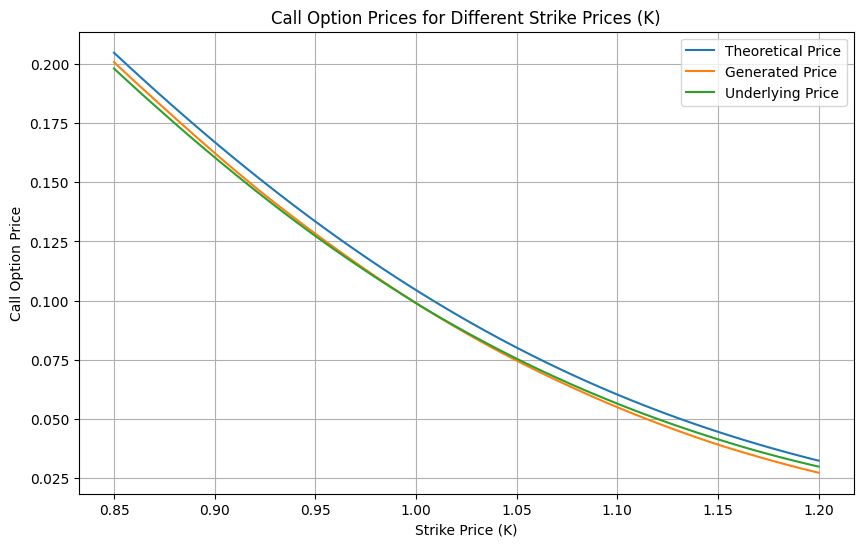

In [5]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt

# Parameters
S0 = 1
r = 0.05
T = n_periods
t = 0
sigma = 0.2

# Define the functions for European call and put
europe_call = lambda x: np.maximum(x - K, 0)
europe_put = lambda x: np.maximum(K - x, 0)

# K values to loop over (fine grid from 0.1 to 2.0)
K_values = np.linspace(0.85, 1.2, 100)

# Store results
exact_prices = []
mc_call_gen_prices = []
mc_call_ul_prices = []

for K in K_values:
    d1 = (np.log(S0/K) + (r + sigma**2/2)*(T-t)) / (sigma*np.sqrt(T-t))
    d2 = d1 - sigma*np.sqrt(T-t)

    exact_call_price = S0*norm.cdf(d1) - K*np.exp(-r*(T-t))*norm.cdf(d2)

    mc_call_gen_price = np.mean(np.exp(-r*(T-t))*europe_call(recovered_paths_df.iloc[:, -1]))
    mc_call_ul_price = np.mean(np.exp(-r*(T-t))*europe_call(underlying_paths_df.iloc[:, -1]))

    exact_prices.append(exact_call_price)
    mc_call_gen_prices.append(mc_call_gen_price)
    mc_call_ul_prices.append(mc_call_ul_price)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(K_values, exact_prices, label='Theoretical Price')
plt.plot(K_values, mc_call_gen_prices, label='Generated Price')
plt.plot(K_values, mc_call_ul_prices, label='Underlying Price')

plt.xlabel('Strike Price (K)')
plt.ylabel('Call Option Price')
plt.title('Call Option Prices for Different Strike Prices (K)')
plt.legend()
plt.grid(True)
plt.show()


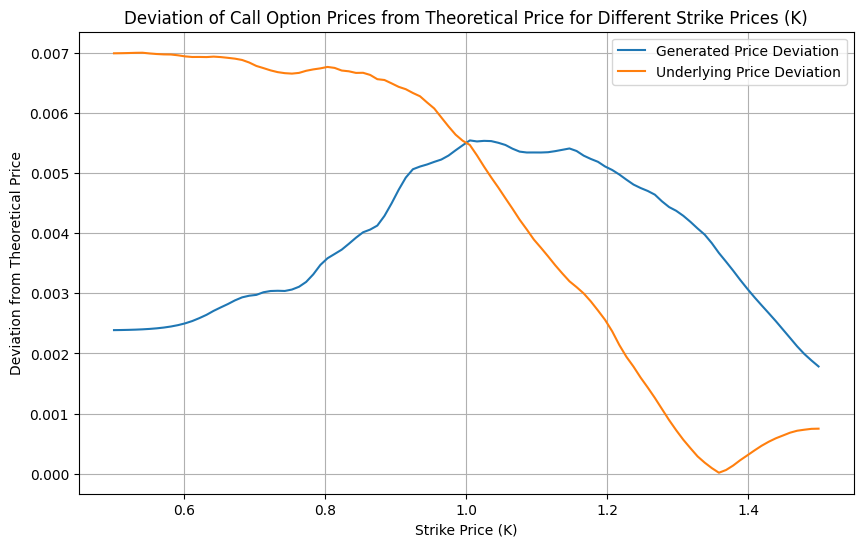

In [6]:
# K values to loop over (fine grid from 0.1 to 2.0)
K_values = np.linspace(0.5, 1.5, 100)

# Store results
gen_deviations = []
ul_deviations = []

for K in K_values:
    d1 = (np.log(S0/K) + (r + sigma**2/2)*(T-t)) / (sigma*np.sqrt(T-t))
    d2 = d1 - sigma*np.sqrt(T-t)

    exact_call_price = S0*norm.cdf(d1) - K*np.exp(-r*(T-t))*norm.cdf(d2)

    mc_call_gen_price = np.mean(np.exp(-r*(T-t))*europe_call(recovered_paths_df.iloc[:, -1]))
    mc_call_ul_price = np.mean(np.exp(-r*(T-t))*europe_call(underlying_paths_df.iloc[:, -1]))

    gen_deviations.append(abs(mc_call_gen_price - exact_call_price))
    ul_deviations.append(abs(mc_call_ul_price - exact_call_price))

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(K_values, gen_deviations, label='Generated Price Deviation')
plt.plot(K_values, ul_deviations, label='Underlying Price Deviation')

plt.xlabel('Strike Price (K)')
plt.ylabel('Deviation from Theoretical Price')
plt.title('Deviation of Call Option Prices from Theoretical Price for Different Strike Prices (K)')
plt.legend()
plt.grid(True)
plt.show()


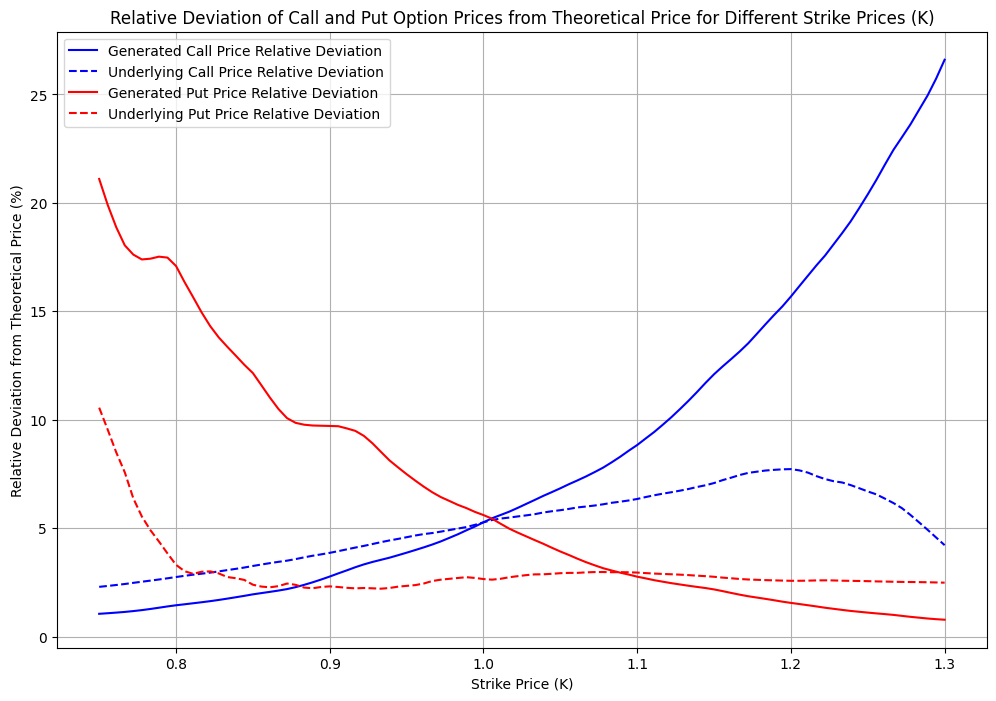

In [7]:
# K values to loop over (fine grid from 0.1 to 2.0)
K_values = np.linspace(0.75, 1.3, 100)

# Store results
gen_call_deviations = []
ul_call_deviations = []
gen_put_deviations = []
ul_put_deviations = []

for K in K_values:
    d1 = (np.log(S0/K) + (r + sigma**2/2)*(T-t)) / (sigma*np.sqrt(T-t))
    d2 = d1 - sigma*np.sqrt(T-t)

    exact_call_price = S0*norm.cdf(d1) - K*np.exp(-r*(T-t))*norm.cdf(d2)
    exact_put_price = K*np.exp(-r*(T-t)) - S0 + exact_call_price

    mc_call_gen_price = np.mean(np.exp(-r*(T-t))*europe_call(recovered_paths_df.iloc[:, -1]))
    mc_call_ul_price = np.mean(np.exp(-r*(T-t))*europe_call(underlying_paths_df.iloc[:, -1]))

    mc_put_gen_price = np.mean(np.exp(-r*(T-t))*europe_put(recovered_paths_df.iloc[:, -1]))
    mc_put_ul_price = np.mean(np.exp(-r*(T-t))*europe_put(underlying_paths_df.iloc[:, -1]))

    gen_call_deviation = abs(mc_call_gen_price - exact_call_price) / exact_call_price * 100
    ul_call_deviation = abs(mc_call_ul_price - exact_call_price) / exact_call_price * 100

    gen_put_deviation = abs(mc_put_gen_price - exact_put_price) / exact_put_price * 100
    ul_put_deviation = abs(mc_put_ul_price - exact_put_price) / exact_put_price * 100

    gen_call_deviations.append(gen_call_deviation)
    ul_call_deviations.append(ul_call_deviation)

    gen_put_deviations.append(gen_put_deviation)
    ul_put_deviations.append(ul_put_deviation)

# Plot the results
plt.figure(figsize=(12, 8))

plt.plot(K_values, gen_call_deviations, 'b-', label='Generated Call Price Relative Deviation')
plt.plot(K_values, ul_call_deviations, 'b--', label='Underlying Call Price Relative Deviation')
plt.plot(K_values, gen_put_deviations, 'r-', label='Generated Put Price Relative Deviation')
plt.plot(K_values, ul_put_deviations, 'r--', label='Underlying Put Price Relative Deviation')

plt.xlabel('Strike Price (K)')
plt.ylabel('Relative Deviation from Theoretical Price (%)')
plt.title('Relative Deviation of Call and Put Option Prices from Theoretical Price')
plt.legend()
plt.grid(True)
plt.show()



In [8]:
# K values to loop over 
K_values = np.concatenate((np.linspace(0.8, 0.95, 4), np.linspace(0.96, 1.05, 10), np.linspace(1.1, 1.25, 4)))

# Store results
results = []

for K in K_values:
    d1 = (np.log(S0/K) + (r + sigma**2/2)*(T-t)) / (sigma*np.sqrt(T-t))
    d2 = d1 - sigma*np.sqrt(T-t)

    exact_call_price = S0*norm.cdf(d1) - K*np.exp(-r*(T-t))*norm.cdf(d2)
    exact_put_price = K*np.exp(-r*(T-t)) - S0 + exact_call_price

    mc_call_gen_price = np.mean(np.exp(-r*(T-t))*np.maximum(recovered_paths_df.iloc[:, -1] - K, 0))
    mc_call_ul_price = np.mean(np.exp(-r*(T-t))*np.maximum(underlying_paths_df.iloc[:, -1] - K, 0))

    mc_put_gen_price = np.mean(np.exp(-r*(T-t))*np.maximum(K - recovered_paths_df.iloc[:, -1], 0))
    mc_put_ul_price = np.mean(np.exp(-r*(T-t))*np.maximum(K - underlying_paths_df.iloc[:, -1], 0))

    gen_call_deviation = mc_call_gen_price - exact_call_price 
    ul_call_deviation = mc_call_ul_price - exact_call_price

    gen_put_deviation = mc_put_gen_price - exact_put_price
    ul_put_deviation = mc_put_ul_price - exact_put_price

    results.append([
        K, 
        exact_call_price, 
        mc_call_gen_price, 
        gen_call_deviation, 
        mc_call_ul_price, 
        ul_call_deviation,
        exact_put_price,
        mc_put_gen_price, 
        gen_put_deviation, 
        mc_put_ul_price, 
        ul_put_deviation
    ])

# Create LaTeX table
latex_table = """
\\begin{table}[H]
\\centering
\\begin{tabular}{
""" 
latex_table += "|C{0.8cm}||C{1.7cm}|C{1.8cm}C{0cm}|C{1.8cm}C{0cm}||C{1.7cm}|C{1.8cm}C{0cm}|C{1.8cm}C{0cm}|}\n"
latex_table += """
\\hline
$K$ & Exact Call Price & Gen Call Price & & UL Call Price & & Exact Put Price & Gen Put Price & & UL Put Price & \\\\
\\hline
"""

for row in results:
    latex_table += " & ".join(
        [
            f"{row[i]:.2f}" if i==0 else 
            f"{row[i]:.6f}" if i==1 or i==6 else 
            "" if i==3 or i==5 or i==8 or i==10 else
            f"{row[i]:.6f} ({row[i+1]:.4f})" for i in range(len(row))
        ]
    ) + " \\\\ \\hline \n"

latex_table += "\n\\end{tabular}\n\\caption{Option Prices and Deviations}\n\\label{tab:option_prices}\n\\end{table}"

print(latex_table)



\begin{table}[H]
\centering
\begin{tabular}{
|C{0.8cm}||C{1.7cm}|C{1.8cm}C{0cm}|C{1.8cm}C{0cm}||C{1.7cm}|C{1.8cm}C{0cm}|C{1.8cm}C{0cm}|}

\hline
$K$ & Exact Call Price & Gen Call Price & & UL Call Price & & Exact Put Price & Gen Put Price & & UL Put Price & \\
\hline
0.80 & 0.245888 & 0.242329 (-0.0036) &  & 0.239126 (-0.0068) &  & 0.006872 & 0.005697 (-0.0012) &  & 0.007099 (0.0002) &  \\ \hline 
0.85 & 0.204693 & 0.200699 (-0.0040) &  & 0.198020 (-0.0067) &  & 0.013238 & 0.011629 (-0.0016) &  & 0.013555 (0.0003) &  \\ \hline 
0.90 & 0.166994 & 0.162365 (-0.0046) &  & 0.160540 (-0.0065) &  & 0.023101 & 0.020857 (-0.0022) &  & 0.023637 (0.0005) &  \\ \hline 
0.95 & 0.133465 & 0.128297 (-0.0052) &  & 0.127345 (-0.0061) &  & 0.037133 & 0.034350 (-0.0028) &  & 0.038002 (0.0009) &  \\ \hline 
0.96 & 0.127300 & 0.122092 (-0.0052) &  & 0.121293 (-0.0060) &  & 0.040480 & 0.037657 (-0.0028) &  & 0.041462 (0.0010) &  \\ \hline 
0.97 & 0.121320 & 0.116067 (-0.0053) &  & 0.115477 (-0.0058) &  & 